In [ ]:
#Mount Google drive to Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install dependencies
!pip install tf-watcher

In [ ]:
# Import packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import tfwatcher
import numpy
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

# Use ImageDataGenerator for data augmenntation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,)
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images
train_generator = train_datagen.flow_from_directory(directory='/content/drive/MyDrive/Data/split_data_1/train', 
                                                    target_size=(224, 224),
                                                    #color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)

valid_generator = valid_datagen.flow_from_directory(directory='/content/drive/MyDrive/Data/split_data_1/val', 
                                                    target_size=(224, 224),
                                                    #color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)


test_generator = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/Data/split_data_1/test',
                                                  target_size=(224, 224),
                                                  #color_mode="grayscale",
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 2900 images belonging to 4 classes.
Found 828 images belonging to 4 classes.
Found 408 images belonging to 4 classes.


In [ ]:
#Create the Model architecture
model= Sequential()

model.add(Conv2D(filters=128,strides= 1, kernel_size = (5,5), activation='relu', input_shape=(224,224,3,)))
model.add(MaxPool2D(3,3))
model.add(Conv2D(filters=64,kernel_size = (5,5),activation='relu'))
model.add(MaxPool2D(3,3))

model.add(Conv2D(filters=32,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=32,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(128,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 32)       0

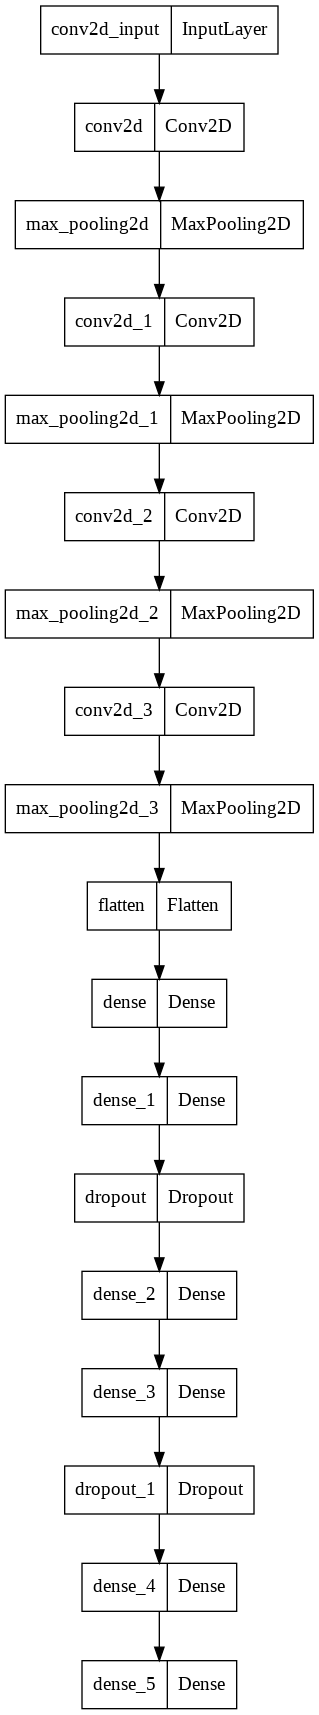

In [ ]:
#Visualize the model
plot_model(model, to_file='vgg.png')

In [ ]:
###### Hyperparameters
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
# Stop the training when there is no improvement after 3 epochs trainings.
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,verbose= 1,
          validation_steps=STEP_SIZE_VALID,
          epochs=100, callbacks=early_stop)

Epoch 1/100
90/90 [==============================] - 76s 847ms/step - loss: 0.3091 - accuracy: 0.8790 - val_loss: 0.3992 - val_accuracy: 0.8425
Epoch 2/100
90/90 [==============================] - 75s 835ms/step - loss: 0.3283 - accuracy: 0.8839 - val_loss: 0.3921 - val_accuracy: 0.8487
Epoch 3/100
90/90 [==============================] - 77s 854ms/step - loss: 0.3060 - accuracy: 0.8874 - val_loss: 0.3574 - val_accuracy: 0.8450
Epoch 4/100
90/90 [==============================] - 75s 834ms/step - loss: 0.2918 - accuracy: 0.8912 - val_loss: 0.4429 - val_accuracy: 0.8325
Epoch 5/100
90/90 [==============================] - 76s 841ms/step - loss: 0.3140 - accuracy: 0.8870 - val_loss: 0.3832 - val_accuracy: 0.8550
Epoch 6/100
90/90 [==============================] - 76s 846ms/step - loss: 0.2880 - accuracy: 0.8999 - val_loss: 0.3949 - val_accuracy: 0.8438
Epoch 7/100
90/90 [==============================] - 75s 834ms/step - loss: 0.2970 - accuracy: 0.8891 - val_loss: 0.3667 - val_accuracy:

In [ ]:
#Save the model to google drice
model.save('/content/drive/MyDrive/models/cnn_model82_100 epochs-last.h5')

In [ ]:
cnn_model = keras.models.load_model("/content/drive/MyDrive/models/cnn_model82_100 epochs-last.h5")

In [ ]:
# Function to evaluate the model
def eval_model(model, test_generator):
    test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    # Get most likely class
    predicted_classes = numpy.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys()) 
    report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report) 
    print(confusion_matrix(true_classes, predicted_classes))

In [ ]:
eval_model(cnn_model, test_generator)

              precision    recall  f1-score   support

       covid       0.84      0.93      0.88       102
      normal       0.88      0.83      0.85       102
   pneumonia       0.95      0.94      0.95       102
tuberculosis       0.99      0.94      0.96       102

    accuracy                           0.91       408
   macro avg       0.91      0.91      0.91       408
weighted avg       0.91      0.91      0.91       408

[[95  5  1  1]
 [15 85  2  0]
 [ 0  6 96  0]
 [ 3  1  2 96]]
